# Preprocessing: PART III (_BL)

**INPUT: _filt.fif files**

...

**Proceed preprocessing using 'clean_ICA.ipynb' file!**

In [1]:
import mne
import os
from utils import check_paths
import re
import copy
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib qt

C:\Users\a1902989\AppData\Local\Temp\ipykernel_14204\706930279.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


**baseline task check**

In [2]:
# set EEG data path, group, task and subject
eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set'
group = 'Y'
sub_name = 's1_pac_sub01'
task = '_BL' # '_RS_OE', '_RS_CE', '_BL', '_MAIN'
filt_dir = os.path.join(eeg_data_dir, group, sub_name, 'preproc', 'filt')
eeg_data_path = os.path.join(filt_dir, f'{sub_name}{task}_filt.fif')
eeg_data_path

'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\s1_pac_sub01\\preproc\\filt\\s1_pac_sub01_BL_filt.fif'

In [3]:
raw_filt = mne.io.read_raw_fif(eeg_data_path, preload=True)
raw_filt

Opening raw data file D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\filt\s1_pac_sub01_BL_filt.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 151453 =      0.000 ...   302.906 secs
Ready.
Reading 0 ... 151453  =      0.000 ...   302.906 secs...


C:\Users\a1902989\AppData\Local\Temp\ipykernel_19736\844640183.py:1: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\filt\s1_pac_sub01_BL_filt.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filt = mne.io.read_raw_fif(eeg_data_path, preload=True)


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,63 points
Good channels,"60 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.50 Hz
Lowpass,80.00 Hz


Using matplotlib as 2D backend.


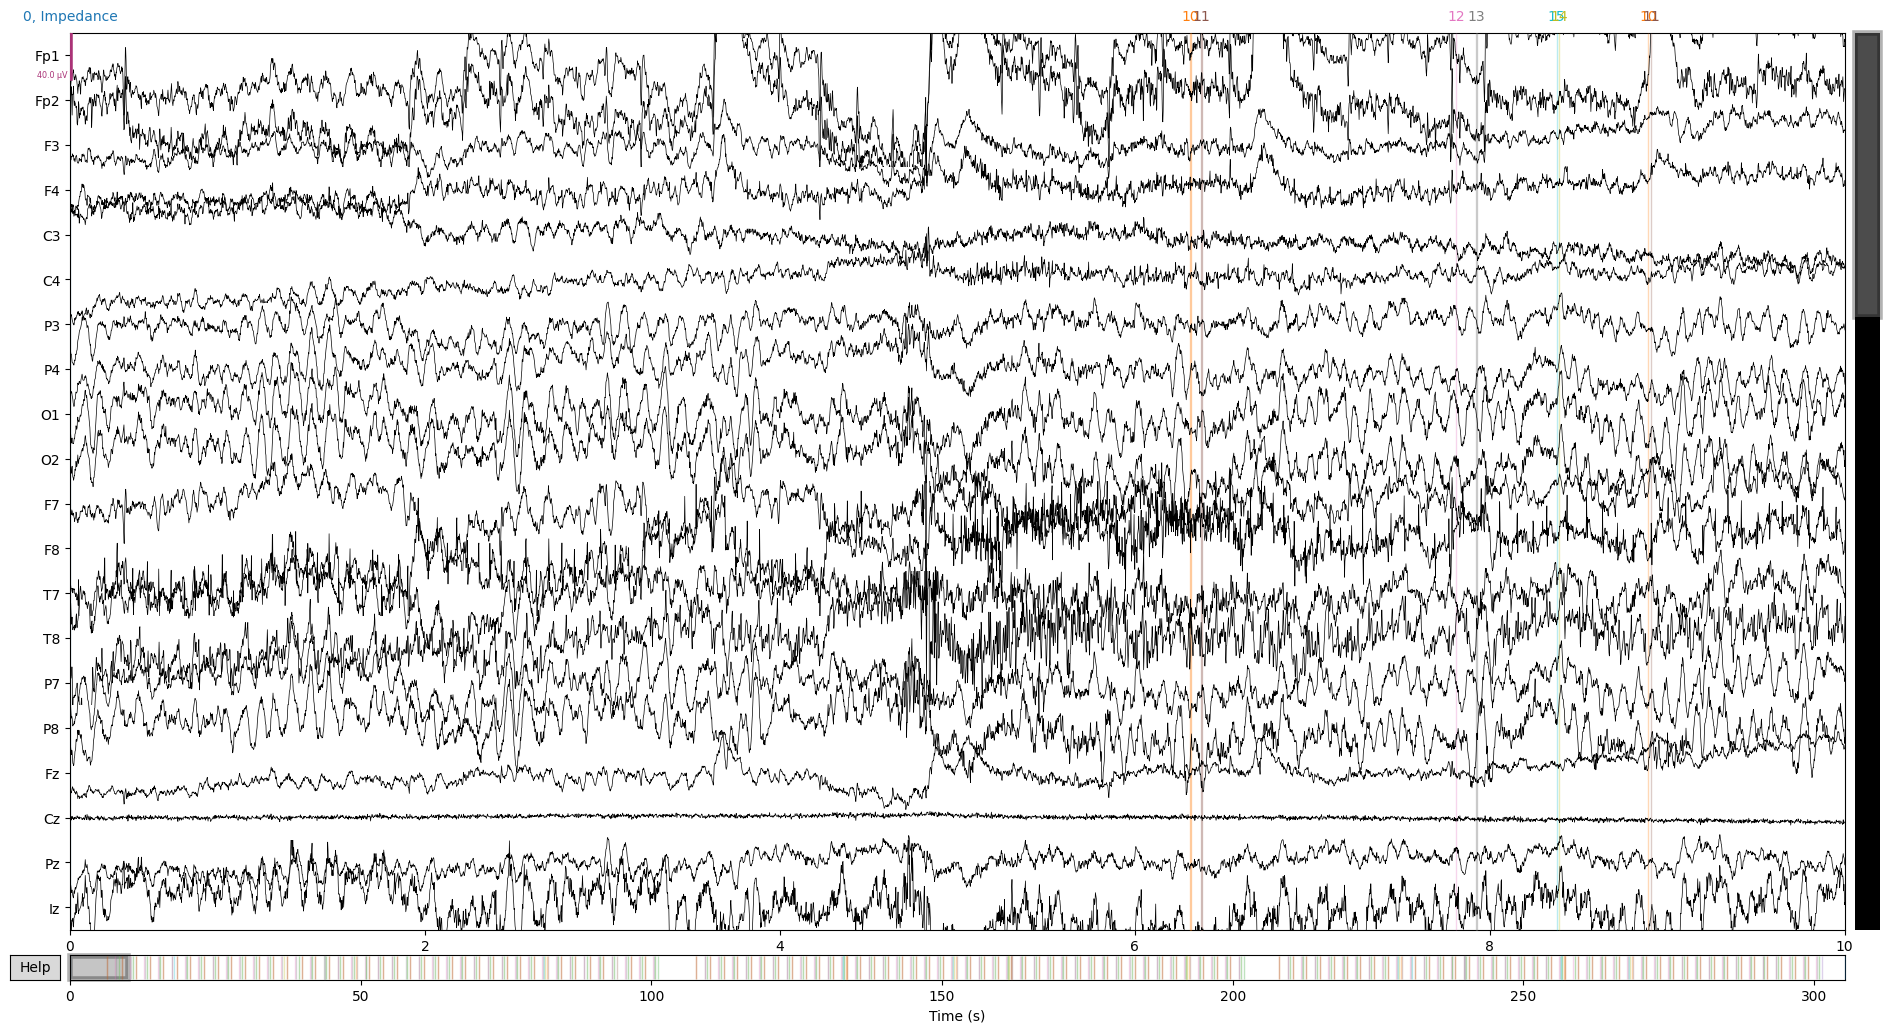

In [4]:
raw_filt.plot()

In [4]:
raw_events = mne.events_from_annotations(raw_filt)
raw_events[1]

Used Annotations descriptions: ['0, Impedance', '10', '102', '103', '11', '12', '13', '14', '15']


{'0, Impedance': 1,
 '10': 2,
 '102': 3,
 '103': 4,
 '11': 5,
 '12': 6,
 '13': 7,
 '14': 8,
 '15': 9}

In [5]:
# Assing events the values corresponding to the keys names
new_events = copy.deepcopy(raw_events)

for key, value in new_events[1].items():
    new_value = int(re.search(r'\d+', key).group())
    new_events[1][key] = new_value
new_events[1]

{'0, Impedance': 0,
 '10': 10,
 '102': 102,
 '103': 103,
 '11': 11,
 '12': 12,
 '13': 13,
 '14': 14,
 '15': 15}

In [6]:
# Create a mapping from the old event values to the new event values
value_mapping = {raw_events[1][key]: new_events[1][key] for key in raw_events[1] if key in new_events[1]}
value_mapping

{1: 0, 2: 10, 3: 102, 4: 103, 5: 11, 6: 12, 7: 13, 8: 14, 9: 15}

In [7]:
# Replace the values in the third column of the events array
for old_value, new_value in value_mapping.items():
    new_events[0][:, 2][new_events[0][:, 2] == old_value] = new_value

In [8]:
new_events

(array([[     0,      0,      0],
        [  3157,      0,     10],
        [  3188,      0,     11],
        ...,
        [150387,      0,     14],
        [150646,      0,    103],
        [152651,      0,      0]]),
 {'0, Impedance': 0,
  '10': 10,
  '102': 102,
  '103': 103,
  '11': 11,
  '12': 12,
  '13': 13,
  '14': 14,
  '15': 15})

BASELINE TASK
100: launch of script
101: start instructions
102: break instructions
103: finish instructions 
10:	new trial
11:	prepare signal (white circle)
12:	inter stimulus interval 1
13:	go signal (green circle)
14:	inter stimulus interval 2
15:	KEY PRESS

In [8]:
bl_dict =  {'0, Impedance': 0,
            'script_start': 100,
            'start_instr': 101,
            'break_instr': 102,
            'finish_instr': 103,
            'new_trial': 10,
            'prepare': 11,
            'isi1': 12,
            'go': 13,
            'isi2': 14,
            'key_press': 15}

In [9]:
# Then, create an inverse mapping of bl_dict
inverse_bl_dict = {v: k for k, v in bl_dict.items()}

# Replace keys in new_events with corresponding keys from main_dict
replaced_keys_dict = {}
for old_key, value in new_events[1].items():
    # Look up the corresponding new key using the value
    new_key = inverse_bl_dict.get(value, old_key)  # Default to old_key if value not found in main_dict
    replaced_keys_dict[new_key] = value

# Output the resulting dictionary
print(replaced_keys_dict)

{'0, Impedance': 0, 'new_trial': 10, 'break_instr': 102, 'finish_instr': 103, 'prepare': 11, 'isi1': 12, 'go': 13, 'isi2': 14, 'key_press': 15}


In [10]:
# Create a final version of an events tuple with correct events and dict with reassigned values
# Step 1: Unpack the tuple
other_element, _ = new_events

# Step 2: Create a new tuple with the new dictionary
new_events = (other_element, replaced_keys_dict)
new_events

(array([[     0,      0,      0],
        [  5129,      0,     10],
        [  5159,      0,     11],
        ...,
        [148284,      0,     14],
        [148542,      0,    103],
        [151453,      0,      0]]),
 {'0, Impedance': 0,
  'new_trial': 10,
  'break_instr': 102,
  'finish_instr': 103,
  'prepare': 11,
  'isi1': 12,
  'go': 13,
  'isi2': 14,
  'key_press': 15})

In [14]:
range(len(new_events) - 1)

range(0, 1)

In [17]:
# SANITY CHECK: if mean significantly deviates from 250 - check the data
to_avg = []
for i in range(len(new_events[0]) - 1):
    if new_events[0][i, 2] == 14:
        if new_events[0][i+1, 2] == 10:
            print(new_events[0][i+1, 0] - new_events[0][i, 0])
            if new_events[0][i+1, 0] - new_events[0][i, 0] < 1000:
                to_avg.append(new_events[0][i+1, 0] - new_events[0][i, 0])

print('Mean:', np.mean(to_avg))

if int(np.mean(to_avg)) not in range(240,260):
    raise ValueError('Mean deviates from 250 - check the data!')

250
250
251
251
251
250
251
250
250
250
250
251
250
251
249
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
251
250
249
250
250
251
250
251
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
251
250
250
251
250
250
250
250
250
251
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
251
250
250
250
250
250
250
250
250
251
249
250
250
251
250
250
250
250
251
Mean: 250.1140350877193


In [19]:
replaced_keys_dict

{'0, Impedance': 0,
 'new_trial': 10,
 'break_instr': 102,
 'finish_instr': 103,
 'prepare': 11,
 'isi1': 12,
 'go': 13,
 'isi2': 14,
 'key_press': 15}

In [35]:
events_final = new_events[0].copy()
upd_events = []

for i in range(len(events_final) - 1):

    # if there's no start
    if events_final[i, 2] == 14:
        if events_final[i+1, 2] != 10 and events_final[i+1, 2] not in range(100,104):
            print('trial:', i,'- no start')
            
            # Add mean timing btw end (14) and start (10)
            new_event_time = events_final[i, 0] + int(np.mean(to_avg))

            # Create a new event with the trigger code 10
            new_event = [new_event_time, 0, replaced_keys_dict['new_trial']]  # [time, 0, trigger code 8]

            # Append the new event to the modified_events array
            upd_events.append(new_event)
            print(new_event)
    
    # if there's no end
    elif events_final[i+1, 2] == 10:
        if events_final[i, 2] != 14 and events_final[i, 2] != 0 and events_final[i, 2] not in range(100,104):
            print('trial:', i,'- no end')
            
            # Add mean timing btw end (14) and start (10)
            new_event_time = events_final[i+1, 0] - int(np.mean(to_avg))

            # Create a new event with the trigger code 14
            new_event = [new_event_time, 0, replaced_keys_dict['isi2']]  # [time, 0, trigger code 9]

            # Append the new event to the modified_events array
            upd_events.append(new_event)
            print(new_event)

# Convert new_events list to a NumPy array
upd_events = np.array(upd_events, dtype=int)

# Combine the original events with the new events
events_final = np.vstack((events_final, upd_events))

# Sort the modified events by the time column (first column)
events_final = events_final[np.argsort(events_final[:, 0])]
            
events_final


trial: 431 - no end
[91384, 0, 14]
trial: 538 - no end
[114676, 0, 14]
trial: 657 - no end
[137501, 0, 14]


array([[     0,      0,      0],
       [  5129,      0,     10],
       [  5159,      0,     11],
       ...,
       [148284,      0,     14],
       [148542,      0,    103],
       [151453,      0,      0]])

In [11]:
# count number of each trigger in RAW events
s1 = pd.Series(raw_events[0][:,2])
s1.value_counts()

2    120
9    120
5    119
6    118
7    117
8    117
1      2
3      2
4      1
Name: count, dtype: int64

In [36]:
# count number of each trigger in RAW events
s2 = pd.Series(events_final[:,2])
s2.value_counts()

10     120
15     120
14     120
11     119
12     118
13     117
0        2
102      2
103      1
Name: count, dtype: int64

In [37]:
# MANUAL CHECK OF EVENTS
for i in range(len(events_final)):
    print(events_final[i])

[0 0 0]
[5129    0   10]
[5159    0   11]
[5876    0   12]
[5934    0   13]
[6068    0   15]
[6076    0   14]
[6326    0   10]
[6334    0   11]
[7051    0   12]
[7109    0   13]
[7221    0   15]
[7226    0   14]
[7476    0   10]
[7484    0   11]
[8201    0   12]
[8259    0   13]
[8366    0   15]
[8367    0   14]
[8618    0   10]
[8626    0   11]
[9342    0   12]
[9401    0   13]
[9464    0   15]
[9467    0   14]
[9718    0   10]
[9726    0   11]
[10442     0    12]
[10501     0    13]
[10562     0    15]
[10567     0    14]
[10818     0    10]
[10825     0    11]
[11542     0    12]
[11601     0    13]
[11722     0    15]
[11726     0    14]
[11976     0    10]
[11984     0    11]
[12700     0    12]
[12759     0    13]
[12868     0    15]
[12875     0    14]
[13126     0    10]
[13134     0    11]
[13850     0    12]
[13909     0    13]
[13976     0    14]
[14226     0    10]
[14234     0    11]
[14950     0    12]
[15009     0    13]
[15365     0    15]
[15367     0    14]
[15617    

In [40]:
# Create a final version of an events tuple with correct events and dict with reassigned values
# Step 1: Unpack the tuple
_, other_element = new_events

# Step 2: Create a new tuple with the new dictionary
new_events = (events_final, other_element)
new_events

(array([[     0,      0,      0],
        [  5129,      0,     10],
        [  5159,      0,     11],
        ...,
        [148284,      0,     14],
        [148542,      0,    103],
        [151453,      0,      0]]),
 {'0, Impedance': 0,
  'new_trial': 10,
  'break_instr': 102,
  'finish_instr': 103,
  'prepare': 11,
  'isi1': 12,
  'go': 13,
  'isi2': 14,
  'key_press': 15})

In [41]:
# Save tuple as a pickle file
with open(os.path.join(filt_dir, f'{sub_name}{task}_events.pkl'), 'wb') as pickle_file:
    pickle.dump(new_events, pickle_file)

print("Events SAVED.")


Events SAVED.


In [42]:
# Open events from pickle file
with open(os.path.join(filt_dir, f'{sub_name}{task}_events.pkl'), 'rb') as pickle_file:
    new_events1 = pickle.load(pickle_file)

new_events1

(array([[     0,      0,      0],
        [  5129,      0,     10],
        [  5159,      0,     11],
        ...,
        [148284,      0,     14],
        [148542,      0,    103],
        [151453,      0,      0]]),
 {'0, Impedance': 0,
  'new_trial': 10,
  'break_instr': 102,
  'finish_instr': 103,
  'prepare': 11,
  'isi1': 12,
  'go': 13,
  'isi2': 14,
  'key_press': 15})

Marking the trials that do not contain [8 20 30 40 9] pattern as BAD

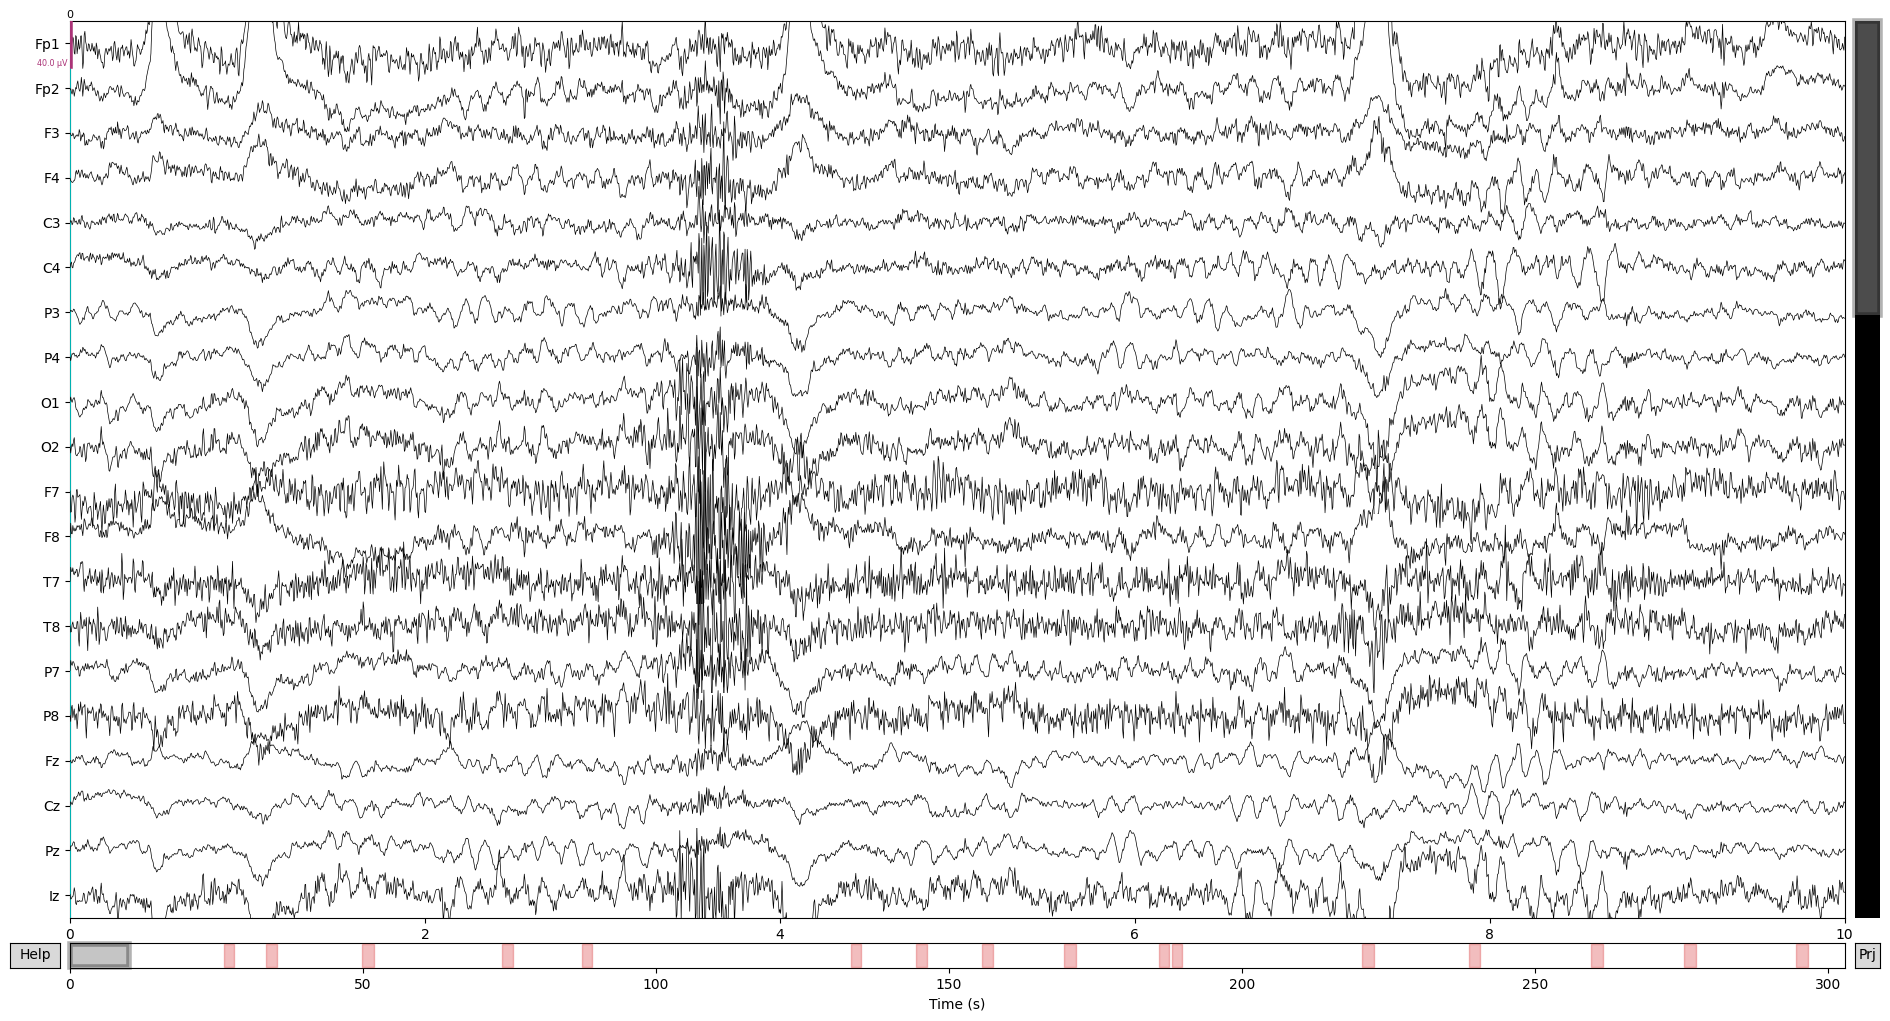

In [46]:
# The correct trigger sequence for a normal trial
correct_sequence = [10, 11, 12, 13, 15, 14]

# Get the sampling frequency from the raw EEG data
sfreq = raw_filt.info['sfreq']

# Find indices of all trial starts (trigger 10)
trial_start_indices = np.where(new_events[0][:, 2] == 10)[0]

# List to store annotations for bad segments
bad_segs = []

# Iterate through each trial start index
for start_idx in trial_start_indices:
    # Find the index of the corresponding '14' trigger (trial_end)
    trial_end_idx = np.where(new_events[0][start_idx:, 2] == 14)[0]
    
    if len(trial_end_idx) > 0:  # Make sure '14' trigger exists after '10'
        trial_end_idx = trial_end_idx[0] + start_idx  # Adjust relative to start_idx
        
        # Extract the potential trigger sequence starting from this trial start
        trigger_sequence = events_final[start_idx:trial_end_idx+1, 2]  # Include '14' in the sequence
        
        # Check if the extracted sequence matches the correct sequence
        if not np.array_equal(trigger_sequence, correct_sequence):
            # Mark this segment as bad from trigger 10 to trigger 14
            start_time = events_final[start_idx, 0] / sfreq  # Convert sample point to time (in seconds)
            end_time = events_final[trial_end_idx, 0] / sfreq  # Time of trigger 14
            
            # Append the bad segment as an annotation
            bad_segs.append((start_time, end_time - start_time, 'bad'))

# Convert bad_segs list to MNE's Annotations format
onsets, durations, descriptions = zip(*bad_segs)
bad_annotations = mne.Annotations(onset=onsets, duration=durations, description=descriptions)

# Add the new annotations to the raw data
raw_filt.set_annotations(bad_annotations)


In [ ]:
# Now the raw data contains annotations for bad segments
raw_filt.plot(events=events_final)

In [45]:
# save filtered file
raw_filt.save(os.path.join(filt_dir, f'{sub_name}{task}_filt_events.fif'), overwrite=True)

Writing D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\filt\s1_pac_sub01_BL_filt_events.fif
Closing D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\filt\s1_pac_sub01_BL_filt_events.fif
[done]


C:\Users\a1902989\AppData\Local\Temp\ipykernel_19736\1890660354.py:2: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\filt\s1_pac_sub01_BL_filt_events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filt.save(os.path.join(filt_dir, f'{sub_name}{task}_filt_events.fif'), overwrite=True)
